# STAT301 Final Project - Group 20

## Introduction
Our global economy drives and depends on functioning companies all around the world, and the characteristics that all organizations have in common are their need and value of their workforce. Employees are one of the most valuable assets and retaining quantity and quality of employees are crucial in running a dependable organization (Negi et. Al, 2013). The failure to do so is called employee attrition, which is a costly challenge faced by many employers around the world. The latter however, is inevitable and managing it is a challenge. Understanding reasons or predictors that could explain employee attrition would provide managers with areas to focus and improve on in the future to improve employee retention (Frye et. Al, 2018). 

## Dataset Description
The dataset chosen: HR Analytics (Konapure & Uikey, 2023) containing 35 different employee factors and characteristics that can be analyzed to understand and interpret organizational data, detecting possible trends and patterns which can be generalized and implemented by companies to assist attrition management. 

**Brief Summary of Entire Dataset**

|Continuous Data|Nominal Data|Ordinal Data|Binary Data|  
|----------------|------------|------------|---------|
|Age           | Employee ID | Frequency of Business Travel | Employee Attrition|
|Daily Wage | Department | Education Level | Over 18|
|Distance to Office | Field of Qualification | Enviromental Satsifcation | Worked Overtime|
|Hourly Rate | Gender | Job Involvement |
|Monthly Income | Marital Status | Job Level |
|Monthly Rate | Job Role | Job Satisfaction 
|Number of Companies Worked | | Performance Rating 
|Percentage Salary Hike | | Relationship Satisfaction 
|Standard Hours | | Stock Option Level 
|Total Working Years| | Work Life Balance
|Training Time |
|Years at Company |
|Years in Current Role |
|Years Since Last Position 
|Years with Current Manager

## Research Question
In our report, we aim to answer the question: **“How can we predict when employees are going to leave?”**

“How can we predict when employees are going to leave? (attrition = 1)” (N)
* Modifying logistic regression to prefer attrition = 1, mention how there’s an imbalance in the response classes
* Discuss how employees departing the company will be a minority (often) of individuals, however we need to design a model using all employee data that can be used to predict the small number of employees that are leaving

“How can we understand what variables are contributing to employee attrition?”
* Using post-lasso to be able to conduct inference
* Idea: splitting data into 3; training-postlasso-test


# Section 2a. Exploratory Data Analysis
To conduct our analysis, we will need to: load the dataset, clean it, and convert it to a tidy format. Below, we load our dataset from the *HR-Employee-Attrition.csv*, convert character columns to factors, and perform a simple check for NA values. Luckily our dataset is already relatively clean from empty values. However, from the dataset description we know that a number of the numeric columns such as `Education` and `JobLevel` represent categorial data. To address this, we will convert all numeric columns with less than 5 distinct values to factors. Finally, we remove superfluous columns such as `Over18`, `EmployeeCount`, `EmployeeNumber`, and `StandardHours` which will not help us predict MonthlyIncome.

In [1]:
suppressMessages(suppressWarnings({
  library(ggplot2)
  library(knitr)
  library(tidyverse)
  library(gridExtra)
  library(kableExtra)
  library(glmnet)
  library(corrplot)
  library(dplyr)
  library(IRdisplay)
  library(webshot)
}))

## Reading & Cleaning Dataset

In [2]:
# Main developer: Bill
# Contributor: Caden

# Load the data and check for NA values
hr_data <- read.csv("HR-Employee-Attrition.csv", stringsAsFactors = TRUE)
print(paste("Number of NA values:", sum(is.na(hr_data))))

# Convert numeric categorial columns to factors
hr_data <- hr_data |> 
    mutate_if(function(col) {
        is.numeric(col) & n_distinct(col) <= 5 
    }, as.factor)

# Remove unnecessary columns
hr_data <- hr_data |> 
    select(-Over18, -EmployeeCount, -EmployeeNumber, -StandardHours)

# Extract response vector and data matrix
y <- hr_data$Attrition
X <- hr_data |> select(-Attrition)

# Display data preview
head(hr_data)

[1] "Number of NA values: 0"


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,⋯,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
,<int>,<fct>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,⋯,3,1,0,8,0,1,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,⋯,4,4,1,10,3,3,10,7,1,7
3,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,⋯,3,2,0,7,3,3,0,0,0,0
4,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,⋯,3,3,0,8,3,3,8,7,3,0
5,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,⋯,3,4,1,6,3,3,2,2,2,2
6,32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,4,Male,⋯,3,3,0,8,2,2,7,7,3,6


## Exploratory Data Analysis - Distribution of Employee Attrition across HR Dataset

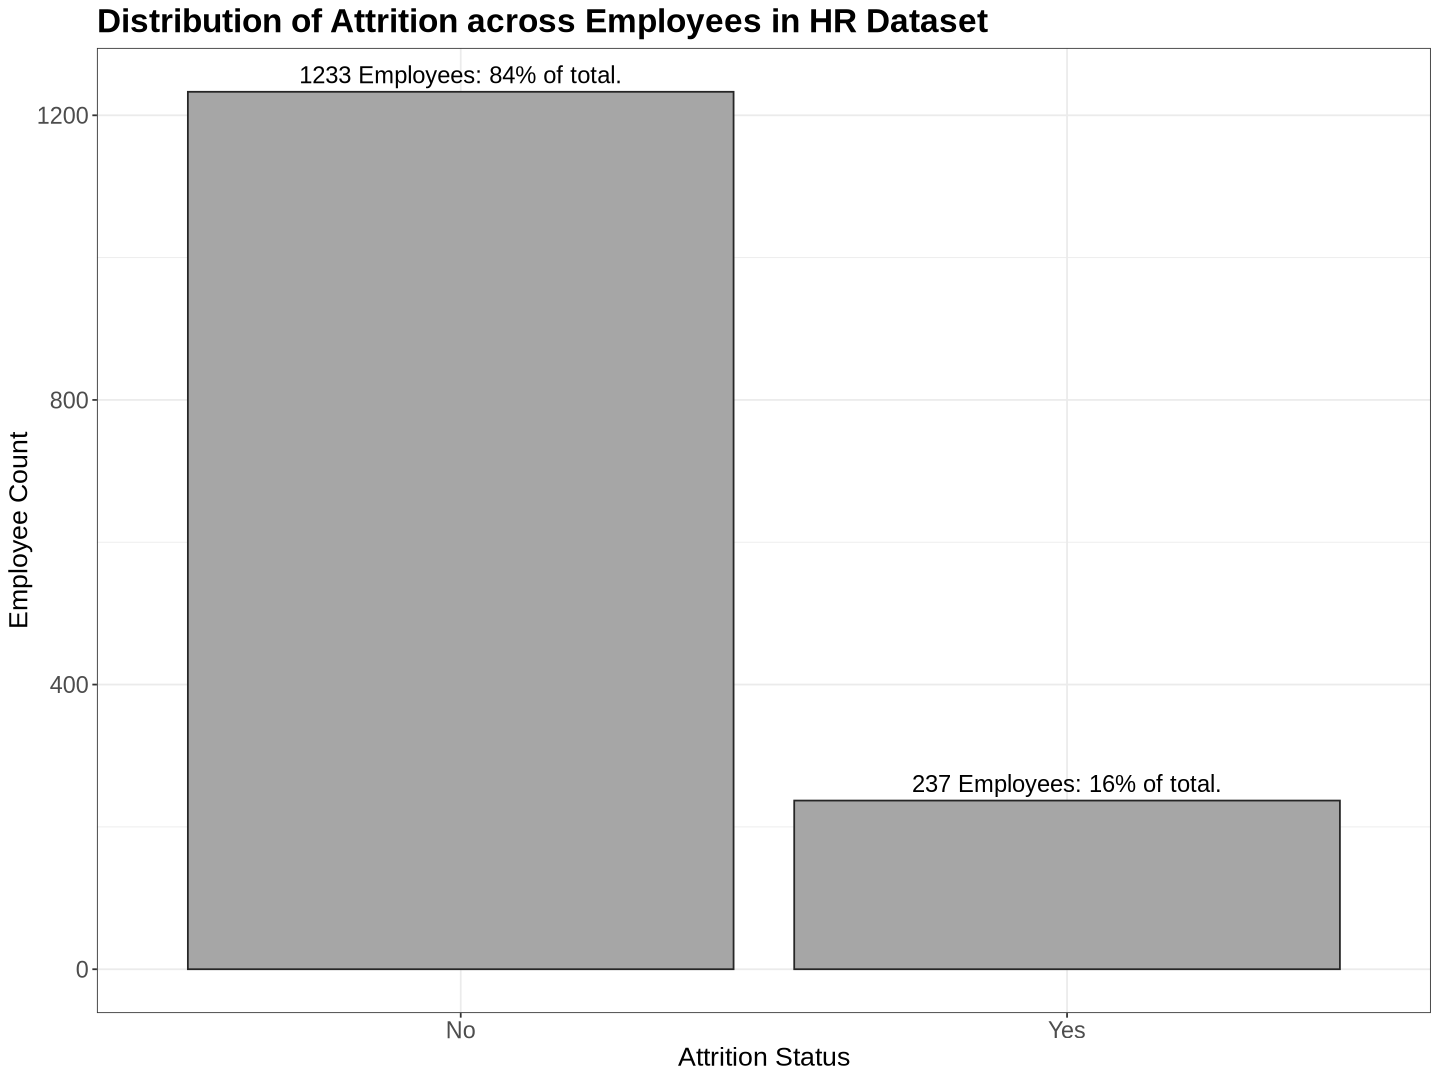

In [3]:
# Main developer: Nusaiba
# Contributor: Caden
options(repr.plot.width = 12, repr.plot.height = 9)
barplot <- hr_data |>
  ggplot() +
  geom_bar(aes(x = Attrition), stat = "count", 
           col = "grey15", fill = "grey65") +
  geom_text(
    stat = "count",
    aes(
      x = Attrition, 
      label = paste0(after_stat(count), " Employees: ",
      100*round(after_stat(count / sum(count)), 2), 
      "% of total.")
    ), 
    vjust = -0.5,
    size = 5
  ) +
  ggtitle("Distribution of Attrition across Employees in HR Dataset") +
  xlab("Attrition Status") +
  ylab("Employee Count") +
  theme_bw() +
  theme(
    plot.title = element_text(color = "Black", size = 20, face = "bold"),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text.x = element_text(size = 14),
    axis.text.y = element_text(size = 14)
  )

barplot

We observe that in the dataset:
* 84% of Employees do not have an attritioned status
* Only 16% of Employees in the dataset have attritioned status

**What does this means for us?** This distribution suggests that there is a class imbalance in the data. Either we should prioritize characteristics and attributes that can predict employee retention, or carefully design our modeling approach to better understand what is causing attrition.

## Correlation Matrix of Variables in Dataset

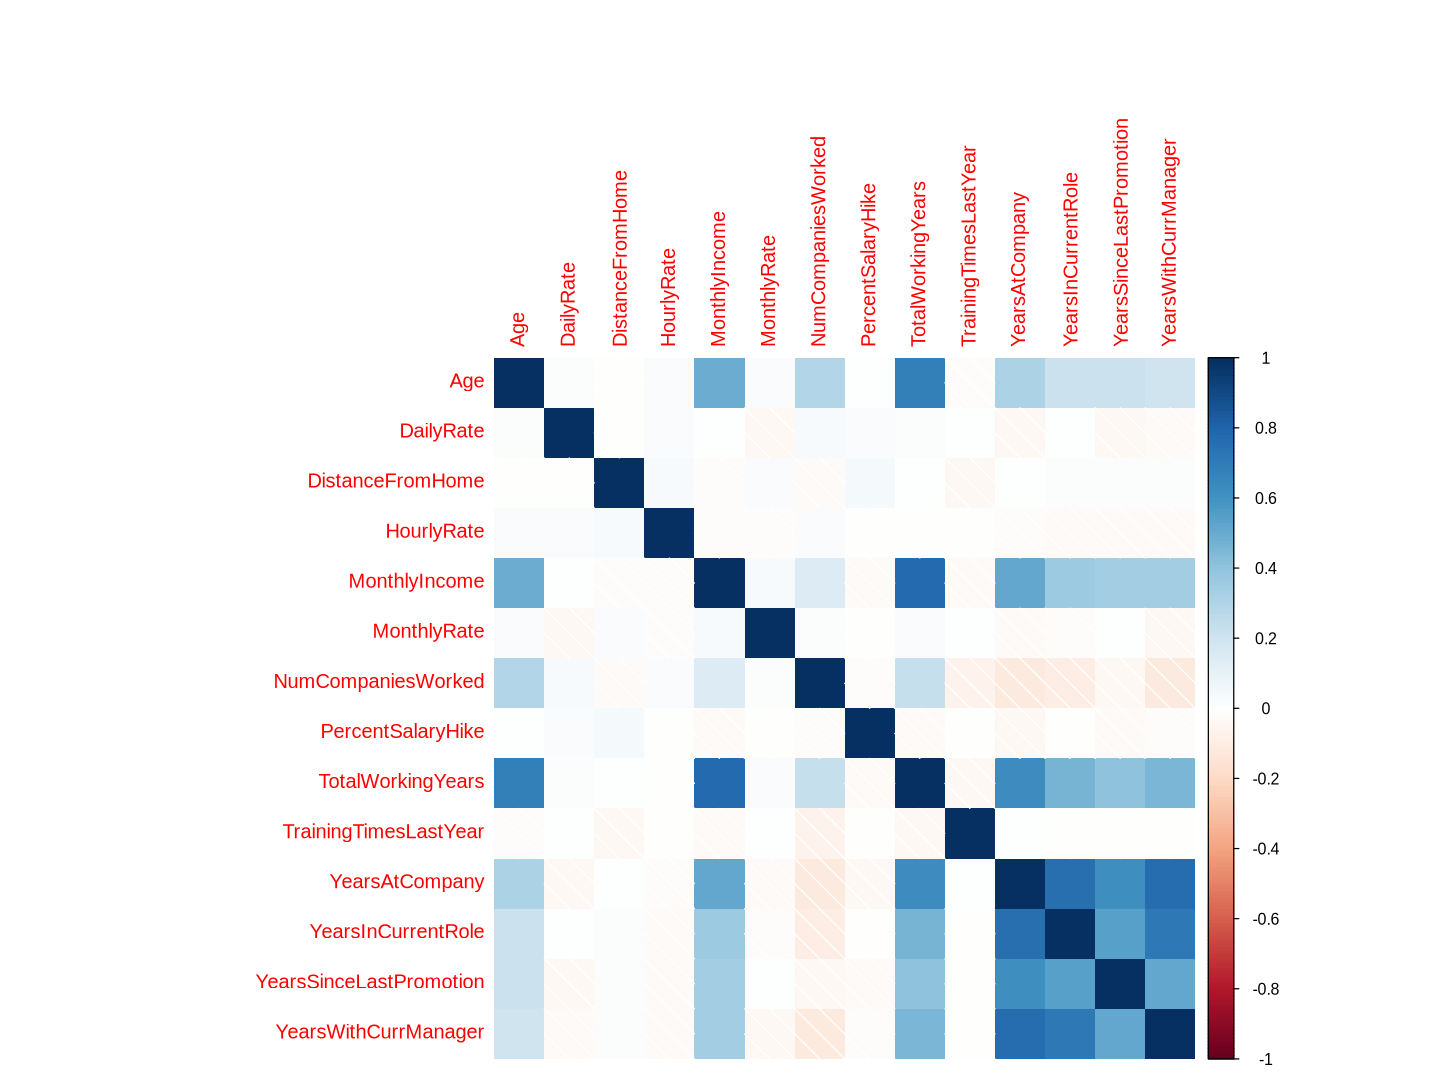

In [4]:
# Main Developer: Kaitlin
# Correlation Matrix to see which factors have impact on each other (highlighting possible confounders present)
cor_matrix <- cor(hr_data[, sapply(hr_data, is.numeric)], use = "complete.obs")
corrplot(cor_matrix, method = "shade") 

### Correlation Matrix Description
Brief Higher-Level Description of Matrix:
* A positive correlation between `MonthlyIncome` with `TotalWorkingYears`, `YearsAtCompany`, `Age`, `YearsInCurrentRole`, `YearsSinceLastPromotion`, `YearsWithCurrManager` and `NumCompaniesWorked` in descending order of correlation strenght. 

Purpose: Overall we observe that these variables are in relation to each other one way or another, for example, an employee with a higher level of education would have a higher chance in landing a higher job level and recieve a higher paying monthly salary which would likely result in the employee staying in the company. Conducting the correlation matrix allows us to get a higher level overview of how the variables might confound one another in the development of the research question.

## Boxplots of Numeric Variables

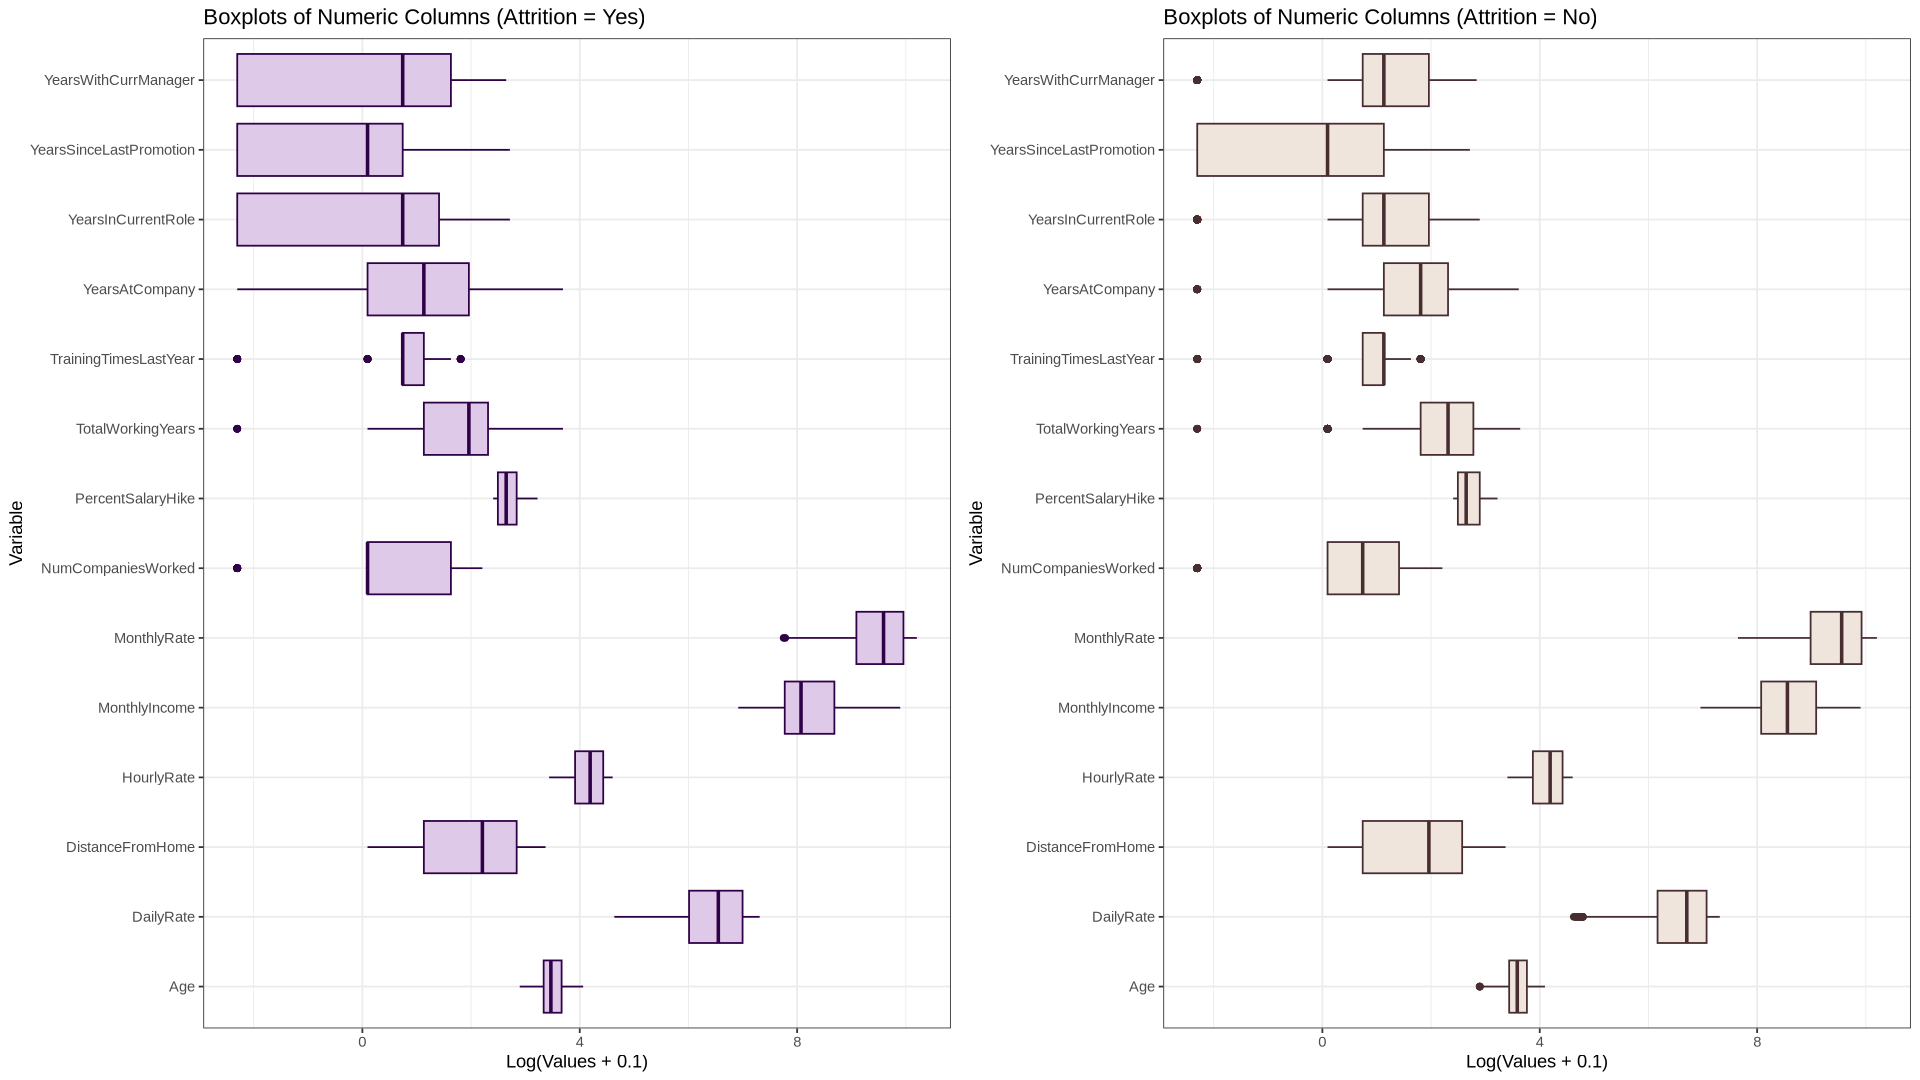

In [5]:
# Main developers: Kaitlin
# Contributors: Bill and Nusaiba
options(repr.plot.width = 16, repr.plot.height = 9)
# Filter and select numeric columns for "Yes" and "No" Attrition
numerics_yes <- hr_data %>%
  filter(Attrition == "Yes") %>% 
  select(where(is.numeric))

numerics_no <- hr_data %>%
  filter(Attrition == "No") %>% 
  select(where(is.numeric))

# Create boxplots for "Yes"
plot_yes <- numerics_yes %>%
  pivot_longer(
    cols = everything(),
    names_to = "Variable", 
    values_to = "Value"   
  ) %>%
  ggplot(aes(x = Variable, y = log(Value + .1))) +
  geom_boxplot(fill = "#dec9e9", color = "#2f0147") +
  coord_flip() + 
  labs(
    title = "Boxplots of Numeric Columns (Attrition = Yes)",
    x = "Variable",
    y = "Log(Values + 0.1)"
  ) +
  theme_bw()

# Create boxplots for "No"
plot_no <- numerics_no %>%
  pivot_longer(
    cols = everything(),
    names_to = "Variable", 
    values_to = "Value"   
  ) %>%
  ggplot(aes(x = Variable, y = log(Value + .1))) +
  geom_boxplot(fill = "#efe5dc", color = "#472d30") +
  coord_flip() + 
  labs(
    title = "Boxplots of Numeric Columns (Attrition = No)",
    x = "Variable",
    y = "Log(Values + 0.1)"
  ) +
  theme_bw()
# Arrange the plots side by side
grid.arrange(plot_yes, plot_no, ncol = 2)

*Note: +0.1 was added so that zero-values would not cause errors on log scale.*

### Boxplot Description & Interpretation:
Displaying a boxplot description of the variables allow us to visualize and understand the distribution and characteristics such as central tendency, variability, skewness, outliers and range between the **Attrition=Yes** and **Attrition=No**. 

*(Log Scale was used because many numerics are on different scales (e.g. `MonthlyIncome` >> `Age`). Additionally, the concentration of values of zero are in `YearsWithCurrManager`, `YearSinceLastPromotion`, etc, are also somewhat different in value across attrition levels.)*

**Main Observation**: Employees tend to leave the company during their earlier years at the company, possibly due to conflicts with current manager, length of years since last promotion or due to personal developments in career ~ wanting to explore other options.

* This can be observed when Attrition=Yes: `YearsWithCurrManager`and `YearsinCurrentRole` have significantly larger spreads on the lower end than Attrition=No, despite having very similar upper fences, means and upper quantiles. Similarly, when comparing `YearsinCurrentRole`, the range when Attrition=No is significantly smaller than when Attrition=Yes, despite similar average years. Furthermore, the spread observed when Attrition=No is relatively smaller than when Attrition=Yes for `YearsAtCompany`.
* Looking at `NumCompaniesWorked`, the average number of companies that Attrition=Yes employees have prior is lower than those in Attrition=No, suggesting that leaving the company could be in result of personal career developments.

Other factors remain somewhat symmetrical as seen above, with some making less conclusive interpretations.

# Section 2b: Methods and Results


## Methods and Plan

There are two interests in our analysis: predicting the probability of an employee leaving, i.e., $\mathbb{P}(\text{Attrition} = 1)$ and discovering the variables that cause employees to leave. However, in the Data Analysis phase, we found that only 16% of responses align with this event. This implies that a naive model's accuracy could be inflated by high specificity when our true goal is to optimize sensitivity and understand the variables impacting it. Indeed, there are many covariates in our data set, and to determine which ones impact employee departure, we need to perform variable selection.


### Model Fitting Process

Considering these requirements, we implemented a weighted logistic regression following LASSO and Post-LASSO procedures. Since our response is binomial, logistic regression is sensible and will provide estimated departure probabilities. Further, as we have many predictors, a LASSO constraint will allow us to select variables (as opposed to Ridge, which cannot.) Indeed, LASSO is a particularly sound choice when there are potentially correlated predictor variables (Zou 2005). Further, a critical aspect of the Post-LASSO procedure is to correct the bias of LASSO's estimated coefficients, allowing us to perform inference and gleam aspects of influential variables on Attrition. 

Before we proceed with the specifics of the fitting process, we will mention the assumptions of this model. In particular, we assume that our observations are independent and there is minimal multi-collinearity. Further, we assume a linear relationship exists between the log-odds of Attrition and the predictor variables and that the errors are independent. Since we are using a post-LASSO procedure for inference, we split the data $60-40$ into a training and inference set. 


Let us now detail the model fitting process. Our objective is to study the effect of increasing the importance of $\text{Attrition} = 1$ on the covariates both in selected variables and significance of coefficients. We thus implement a weighted logistic regression model. 

We begin by declaring a maximal weight of interest $\omega$. For our experiment we declared $\omega = 10$. Then, we iterated through integer weights $w$ between $1$ (unweighted) and $\omega$. For each $w \in [1, 10]$, we define a vector of weights $\vec{\mathbf{w}}$ which is assigned a value of $w_i = w$ if $y_i = 1$ and $w_i = 1$ otherwise. The weights assigned to observations $\vec{\mathbf{y}}$ is the only thing changing between iterations $w \in [1, 10]$. To ensure comparability between models, we use the same seed, training set, etc. for all weights. To select variables and fit coefficients for a given iteration's $\vec{\mathbf{w}}$, we optimize the weighted log-likelihood under the LASSO regularization constraint and select the $\lambda$ value which minimizes the cross-validated error ($\hat{\lambda}_{\text{min}}$). This is done usign `cv.glmnet`, which estimates the solution of the following using quadratic forms (Friedman 2010):
$$
\hat{\boldsymbol{\beta}} = \text{argmin}_{\boldsymbol{\beta{ \in \mathbb{R}^{p+1}}}}\bigg\{\sum_{i = 1}^n w_i\Big[ - \log \big(1 + \exp(-\mathbf{x}_i^{\top} \boldsymbol{\beta})\big) -(1 - y_i)\mathbf{x}_i^{\top} \boldsymbol{\beta} \Big]  + \lambda \sum_{j = 1}^{p + 1}|\beta_j |\bigg\}
$$
Notice that weights $w_i$ are applied to the contribution of an observation to the log-likelihood but not to the $\ell_1$ regularization constraint. Consequently, as noted by the authors of `cv.glmnet`, the presence of weights does not change the computational costs as long as the weights remain fixed (Friedman et. al, 2010). For each $w \in \{1, 10\}$ we select the regularization weight $\lambda =  \hat{\lambda}^{(w)}_{\text{min}}$ which minimizes the $15$-fold cross validated error. Then, using the selected covariates under $\hat{\lambda}_{\text{min}}$ we compute the fitted values for this weighted model ($\hat{\mathbf{y}}_{w}$) and calculate the the in-sample confusion matrix values (denoted $\mathbf{C}_w$), the $F_1$ statistic and the $F_\beta$ statistic with $\beta = 2$ which we justify in the next section. Since we track these statistics across different weighted models we denote the statistics $\mathcal{F}_1^{(w)}$ and $\mathcal{F}_\beta^{(w)}$ respectively. In addition we store the selected covariates for each weighted model, denoted $\mathbf{S}_w$. Thus, for each $w \in [1,10]$ we compute $\mathcal{M}_w = \{ \hat{\boldsymbol{\beta}}^{(w)}, \mathbf{S}_w, \mathbf{C}_w, \mathcal{F}_1^{(w)}, \mathcal{F}_\beta^{(w)} \}$, i.e. the LASSO model, the selected covariates, the confusion matrix and $F$-statistics respectively. Notably, $\mathcal{M}_1$ contains the LASSO model, coefficients and in-sample performance metrics when $w_i = 1$ regardless of the value of $y_i$ which we refer to as the "unweighted" model. This allows us to have a both a baseline for comparison and a comprehensive perspective on the effects on in-sample fitness of weighing $\text{Attrition} = 1$ by different integer weights in $1$ to $10$. 


### Explanation

Recall that the objective is to study the effects of prioritizing the minority class on the covariates. While by nature this is an inference problem, the above process selects the weight $w$ for which we maximize $F_{\beta}$ for $\beta = 2$. Given a confusion matrix $\mathbf{C}_w$ we can compute the number of True Positives (`TP`), False Positives (`FP`), True Negatives (`TN`) and False Negatives (`NP`). From these values we compute the $F_{\beta}$ and $F_1$ scores as follows:
$$
F_{\beta} = \frac{(1 + \beta^2) \cdot \text{TP}} {(1 + \beta^2) \cdot \text{TP} + \beta^2 \cdot \text{FN} + \text{FP}} \hspace{0.75cm} \overset{\beta = 1}{\longrightarrow} \hspace{0.75cm} F_{1} = \frac{2 \text{TP}} {2 \text{TP} + \text{FN} + \text{FP}} 
$$
For $\beta = 1$, the above fitness metric balances precision and sensitivity. Hence, if the model first majority class $\text{Attrition} = 0$ well but fits the minority class $\text{Attrition} = 1$ poorly, it will have high precision and low sensitivity. Consequently, it may not have a high $F_1$ score. Due to the class imbalance, we anticipate this may be the case in our data set. When we weigh the log-likelihood contributions of the minority class by a constant coefficient, this increases the influence of the minority class on the coefficients. One can think of it as increasing the penalty to the log-likelihood of incorrectly predicting the minority class (i.e. a False Negative.) This will then "guide" the coefficients in the direction of higher sensitivity at the potential cost of accuracy and precision; however, such a model may have a better balance between precision and accuracy and thus a *higher* $F_1$ score than the baseline.


While we are interested to see if such a $w$ exists that improves the $F_1$ score over the baseline, we are more interested in studying the effect on the fitted coefficients and selected variables of prioritizing $\text{Attrition} = 1$ over the majority class. This is where we use the $F_{\beta}$ score. The $F_{\beta}$ value is a special case of the $F_1$ score wherein we attach $\beta$ times as much importance to sensitivity as precision (Rijsbergen, 1979). In our case, we explore the effect of attaching $\beta = 2$ times as much importance to $\text{Attrition} = \text{``Yes"} (1)$ over $\text{``No"} (0)$. We then select the weighted model $\mathcal{M}_w$ that maximizes this score. We anticipate that the chosen $w$ will be higher for the $F_{\beta}$ maximized model than the $F_1$ model. 

We hence will compare the coefficients and performance metrics of three models; the unweighted model $\mathcal{W}_{\oslash}$, the model which maximizes in-sample $F_1$ score $\mathcal{W}_{1}$ and the model which maximizes the in-sample $F_\beta$ score $\mathcal{W}_{\beta}$. As detailed in the next section, we use a held-out set to conduct inference on the significance of the selected variables' coefficients across the three models as well as comparing the in-sample and held-out performance metrics. 


### Post-LASSO for Inference

We note that the previously discussed process involves training data and LASSO-selected covaraites. Further, the rigorous iterative process may lend itself to overfitting our model to the training data. To reduce the bias of the LASSO coefficients and test against overfitting, we fit a post-LASSO `glm` using the selected covariates and weights across all three models $\mathcal{W}_{\oslash}$, $\mathcal{W}_{1}$, and $\mathcal{W}_{\beta}$. This will allow us to compare the in-sample and held-out Accuracy, Sensitivity, Precision, $F_1$ and $F_\beta$ scores to see if the selected weights for $\mathcal{W}_{1}$, and $\mathcal{W}_{\beta}$ improve the held-out sensitivity and $F_1$ / $F_\beta$ scores respectively. These values are detailed in Table 1 in the next section.

Using a post-LASSO procedure will allow us to have unbiased coefficient estimates. We leverage this fact to compare the selected variables and the significance of their coefficients between the $\mathcal{W}_{\oslash}$ and $\mathcal{W}_{\beta}$ models. Recalling that the $\mathcal{W}_{\beta}$ model is selected by prioritizing $\text{Attrition} = \text{``Yes"} (1)$ as twice as important as $\text{Attrition} = \text{``No"} (0)$ this will allow us to infer which covariates become more significnat as we prioritize estimating employee departure. This is shown in Figure 4 in the next section.

## Implementation of a Proposed Model
Now we define a new function for assessing the performance of a logistic regression model. Given a Confusion Matrix `conf_in`, it extracts the number of True Positives (`TP`), False Positives (`FP`), True Negatives (`TN`) and False Negatives (`NP`). From these values, we compute Accuracy, Precision, Sensitivity and Specificity and return it as a `list`. In addition, we compute the $F_1$ and $F_{\beta}$ scores.

In [6]:
# Main developer: Caden
# compute the performance metrics given a conf. matrix
compute_metrics <- function(conf_in, beta = 2){
  # extract table info
  TP <- conf_in[2, 2]
  FP <- conf_in[2, 1]
  TN <- conf_in[1, 1]
  FN <- conf_in[1, 2]
  # compute metrics
  accuracy <- (TP + TN) / sum(conf_in)
  precision <- TP / (TP + FP)
  sensitivity <- TP / (TP + FN)
  specificity <- TN / (TN + FP)
  # compute F1 score
  F1 <-  2*TP / (2*TP + FP + FN)
  # compute F-beta score. Defaults to F2
  FB <- (1 + beta^2) * TP / ((1 + beta^2) * TP + beta^2 * FN + FP)
  # return everything
  return(list(
    ACC = accuracy,
    PRE = precision,
    SEN = sensitivity,
    SPC = specificity,
    F1  = F1,
    FB  = FB
  ))
}

Now, we fix the seed and designate a training set and an inference set. We will use a $60-40$ split. We also define the `model.matrix` to get our covariates ready for input into `glmnet`. 

In [7]:
# Main developer: Caden
# Contributor: Bill
set.seed(42)
# rename to match my conventions
df <- hr_data
# train-test split: 60-40
train_indices <- sample(1:nrow(df), size = 0.60 * nrow(df), replace = FALSE)
train <- df[train_indices, ]
# get unselected indices
inference  <- df[-train_indices, ]
# prepare data for glmnet
x <- model.matrix(Attrition ~ . - 1, data = train)
y <- as.numeric(train$Attrition == "Yes")
# write train and inference response as boolean
train$Attrition <- as.numeric(train$Attrition == "Yes")
inference$Attrition <- as.numeric(inference$Attrition == "Yes")

Then, for weights $w \in [1,10]$ we apply a weight of $w$ to the set of $\{y \in \mathbf{\vec{y}} \mid y = 1\}$ to follow the procedure described in the Methods section. Then, for each weight, we construct a model $\mathcal{M}_w$ by selecting the variables using Lasso Constraints and cross-validation. Then, we compute and record the in-sample metrics and store the model information in the `models_list`. 

In [8]:
# Main developer: Caden

# ----------------------- #
# ---- Model Fitting ---- #
# ----------------------- #

# define weights and lists
weights_list <- 1:10
models_list <- list()
results_rw <- list()
perf_list <- list()
# iterate across weights results
for(w in weights_list){
  
  # increase weight of employee leaving by `w`
  weights <- ifelse(y == 1, w, 1)
  
  # ----------------------- #
  # --- Logistic LASSO ---- #
  # ----------------------- #
  # CV Lasso Logistic
  cv_logistic <- cv.glmnet(
    x, y,
    # using LASSO 
    alpha = 1,
    # weights in this iteration
    weights = weights,
    # logistic regression
    family = "binomial",
    # 15-fold CV
    nfolds = 15
  )
  # in-sample predictions
  yhat_lasso <- as.numeric(predict(
    cv_logistic,
    newx = x,
    s = "lambda.min",
    type = "response"
  ) > 0.5)
  # compute confusion matrix metrics
  mat_ins_w <- compute_metrics(table(yhat_lasso, y), beta = 2)
  
  # ----------------------- #
  # --- Selected Vars. ---- #
  # ----------------------- #
  # then extract chosen variables
  coefs_min <- coef(cv_logistic, s = "lambda.min")
  s_min <- rownames(coefs_min)[which(coefs_min != 0)]
  s_min <- s_min[s_min != "(Intercept)"]
  # match training columns to the original columns
  matched_columns <- unique(sapply(s_min, function(var) {
    # match selected columns+factor levels to
    matches <- colnames(df)[which(sapply(colnames(df), function(orig)
      grepl(orig, var)))]
    if (length(matches) > 0) {
      # get longest match name (e.g. EducationField vs. Education)
      matches[which.max(nchar(matches))]
    }
  }))
  # store chosen variables
  models_list[[w]] <- matched_columns

  # ---------------------- #
  # --- Perf. Metrics ---- #
  # ---------------------- #
  # report metrics
  results_rw[[w]] <- data.frame(train = round(
    c(
      ACC  = mat_ins_w$ACC,
      PRE  = mat_ins_w$PRE,
      SEN  = mat_ins_w$SEN,
      SPC  = mat_ins_w$SPC,
      # also extract the F1 score
      F1  = mat_ins_w$F1,   
      # and the F2 (beta = 2) score
      FB  = mat_ins_w$FB,
      # estimated difference in accuracy-sensitivity
      DLT  = abs(mat_ins_w$ACC - mat_ins_w$SEN),
      # estimated difference in accuracy-sensitivity
      AVG  = mean(mat_ins_w$ACC, mat_ins_w$SEN),
      # also report Mean Cross-Validated Error at Lambda Min
      CVM  = cv_logistic$cvm[which(cv_logistic$lambda == cv_logistic$lambda.min)],
      # and the Estimate of Standard Error of CVM
      CVSE = cv_logistic$cvsd[which(cv_logistic$lambda == cv_logistic$lambda.min)]
    ),
    3
  ))
}

Then, we clean the results of the algorithm and compute $w^{\star}$ as $\text{argmin}_{w \in [1, \omega]}(\mathcal{P}_w)$.

In [14]:
# Main developer: Caden
# --------------------- #
# --- Clean Output ---- #
# --------------------- #
results_clean <- do.call(cbind, results_rw)
colnames(results_clean) <- paste0("w=", weights_list)
# which has the highest F1 score
best_w_f1 <- which.max(results_clean["F1", ])
# which has the highest FB score
best_w_fb <- which.max(results_clean["FB", ])
cat(paste0("The weight corresponding to the best training-set LASSO under the F1 statistic is w=",  best_w_f1, ".\n"))
cat(paste0("The weight corresponding to the best training-set LASSO under the FB statistic is w=", best_w_fb, "."))

The weight corresponding to the best training-set LASSO under the F1 statistic is w=2.
The weight corresponding to the best training-set LASSO under the FB statistic is w=6.

Now to help regulate the bias of LASSO we fit a Logistic Model using `glm` and the held-out set.  We fit a post-LASSO $w = 1$ (the "Baseline" or "Unweighted") model and a $w = w^{\star}$ ("Weighted") model. We use the covariates saved in `models_list` from the main training loop for each model, implying that different covariates could be selected for the different models. 

In [15]:
# Main developer: Caden
# ------------------- #
# --- Post-LASSO --- #
# ------------------- #
# get the columns of best f1 weight and append response
post_lasso_df <- inference[, c("Attrition", models_list[[best_w_f1]])]
# compute weights according to best result
weights_f1 <- ifelse(post_lasso_df$Attrition == 1, best_w_f1, 1)
# use regular glm to train post-lasso model
mod_post_lasso <- glm(Attrition ~ ., weights = weights_f1,
                      data = post_lasso_df,family = "binomial")

# repeat for fb weight
post_lasso_df_b <- inference[, c("Attrition", models_list[[best_w_fb]])]
# compute weights according to best result
weights_fb <- ifelse(post_lasso_df$Attrition == 1, best_w_fb, 1)
# use regular glm to train post-lasso model
fb_post_lasso <- glm(Attrition ~ ., weights = weights_fb,
                      data = post_lasso_df, family = "binomial")

# ------------------ #
# ---- Baseline ---- #
# ------------------ #
# get the columns of the unweighted model from LASSO
baseline_df <- inference[, c("Attrition", models_list[[1]])]
# use regular glm to train baseline post-lasso model
baseline_post_lasso <- glm(Attrition ~ .,
                           data = baseline_df,
                           family = "binomial")
# -------------------- #
# -- Inference Set -- #
# ------------------- #
# baseline post-LASSO fitted values
base_preds <- predict(baseline_post_lasso, newdata = inference, type = "response") > 0.50
# weighted post-LASSO fitted values
post_preds_f1 <- predict(mod_post_lasso, newdata = inference, type = "response") > 0.50
post_preds_fb <- predict(fb_post_lasso, newdata = inference, type = "response") > 0.50
# compute confusion matrix for baseline
perf_PB <- compute_metrics(table(base_preds, inference$Attrition))
# and for F1/FB models
perf_PFB <- compute_metrics(table(post_preds_fb, inference$Attrition))
perf_PF1 <- compute_metrics(table(post_preds_f1, inference$Attrition))

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Further, we compute the out-of-sample performance for both post-LASSO `glm` fits, so we can assess whether the weighted model is predicting $\text{Attrition} = 1$ better than the baseline model. In addition, we extract the training performance from the original LASSO fitting process for each model. We thus have three

In [16]:
# Main developer: Caden
# ------------------- #
# -- Clean Results -- #
# ------------------- #

# get the training performance for both weighted and unweighted
lasso_FB <- t(results_rw[[best_w_fb]])[1:6]
lasso_L <- t(results_rw[[best_w_f1]])[1:6]
lasso_B <- t(results_rw[[1]])[1:6]
# summarize results
results = data.frame(
  lasso_WTB = lasso_FB,
  post_WTB  = round(unlist(perf_PFB), 3),
  lasso_WT1 = lasso_L,
  post_WT1  = round(unlist(perf_PF1), 3),
  lasso_UW  = lasso_B,
  post_UW   = round(unlist(perf_PB), 3)
)
# set column names (will become row names)
colnames(results) <- rep(c("Lasso", "Post-Lasso"), times = 3)
# transpose the results matrix so it makes more sense when presented
results <- t(results)
# add the column selection metrics
# select column names of both without "Attrition"
S_fb <- models_list[[best_w_fb]]
S_BL <- models_list[[1]]
S_f1 <- models_list[[best_w_f1]]
# append the number of selected variables for each model
results <- cbind(results, K = c(length(S_fb), "",
                                length(S_f1), "", 
                                length(S_BL), ""))
# --------------------- #
# -- Construct Table -- #
# --------------------- #
results_table <- kable(
  results, 
  col.names = c(
    "Accuracy", "Precision",
    "Sensitivity", "Specificity",
    "F<sub>1</sub> Score", "F<sub>β</sub> Score",
    "Variables Selected"
  ),
  caption = "Table 1: Summary of Performance Metrics Across Models",
  escape = FALSE,  
  format = "html"  
) %>%
  # manually add html alignment/styling to titles so it renders in Jupyter nicely
  pack_rows('<div style="text-align: left;">F<sub>β</sub> Score Preferred Model</div>', 1, 2, escape = FALSE) %>%
  pack_rows('<div style="text-align: left;">F<sub>1</sub> Score Preferred Model</div>', 3, 4, escape = FALSE) %>%
  pack_rows('<div style="text-align: left;">Unweighted Model</div>', 5, 6, escape = FALSE) %>%
  kable_styling(
    font_size = 12
  ) %>% 
  column_spec(1:7, width = "2.5cm")

results_table %>%
  as.character() %>%
  display_html()


Table 1: Summary of Performance Metrics Across Models 
 
 
 
 Accuracy 
 Precision 
 Sensitivity 
 Specificity 
 F 1 Score 
 F β Score 
 Variables Selected 
 
 
 
 F β Score Preferred Model 
 
 Lasso 
 0.805 
 0.44 
 0.863 
 0.794 
 0.583 
 0.724 
 29 
 
 
 Post-Lasso 
 0.825 
 0.486 
 0.908 
 0.808 
 0.633 
 0.774 
 
 
 F 1 Score Preferred Model 
 
 Lasso 
 0.9 
 0.689 
 0.669 
 0.943 
 0.679 
 0.673 
 28 
 
 
 Post-Lasso 
 0.895 
 0.67 
 0.724 
 0.929 
 0.696 
 0.713 
 
 
 Unweighted Model 
 
 Lasso 
 0.904 
 0.846 
 0.475 
 0.984 
 0.608 
 0.521 
 28 
 
 
 Post-Lasso 
 0.912 
 0.811 
 0.612 
 0.971 
 0.698 
 0.644

**Interpretation of Table 1 (outline)**
  - The $F_{\beta}$ model (which weighs $\text{Attrition} = 1$ at $w = 6$) has high sensitivity both in-sample and in the inference set.  The sensitivity, i.e. proportion of true positives detected, relative to the total number of actual positives, is around $30\%$ higher than the baseline model and $17\%$ higher than the $F_1$ model. This comes at a cost of about $10\%$ overall accuracy for $F_\beta$.
  - To contrast, the $F_1$ model (which weighs $\text{Attrition} = 1$ at $w = 2$) strikes a balance between the $F_{\beta}$ and unweighted models. It has an increase in sensitivity of about $10\%$ relative to the baseline at no substantial cost (appx. $1\%$) to the accuracy and with slight cost to the precision.
  - Finally, the unweighted model has the best overall accuracy, which is reflected in higher precision and specificity. However, it is only detecting true positives around $47.5\%$ of the time (relative to the true number of positives) in the training data and around $60\%$ in the test data.

**Some thoughts**
- If our goal was prediction, we could potentially prefer the $F_1$ model. It is likely to have better test set performance. This is because it seems to be expressing a balance of all metrics (precision/sensitivity/$F_1$/accuracy/etc.) compared to the other two models. If we had a representative test set it would likely (though not guaranteed until we test) have fewer false negatives than the baseline and fewer false positives than the $F_{\beta}$. Though it may not have the best overall accuracy.
- Precision roughly equal to accuracy ($F_1$: what weight roughly balances precision and sensitivity.)
- Since our goal is to study the effects of attaching more value to $\text{Attrition} = 1$ relative to $\text{Attrition} = 0$ on the coefficient estimates, we will investigate further the differences between the $F_{\beta}$ model and the unweighted model. By construction, the $F_{\beta}$ score is under the assumption that  "the user who attaches $\beta$ times as much importance to [sensitivity] as precision" (Rijsbergen, 1979). In our case, the model was selected under the assumption we attach $\beta = 2$ times as much importance to Attrition = "Yes" (1) to "No" (0).
- To contrast, both the unweighted and $F_1$ models are treating them with *equal* importance. Despite the fact that $F_1$ selected $w = 2$ this is simply the weighing of Attrition = 1 that maximized the harmonic mean of precision and sensitivity (Abdel 2015) for the integer weights provided in the test set.


We now extract the $p$-values for the coefficients for both models and convert them to log scale. On each plot, we include vertical lines corresponding to the logarithm of $\alpha \in \{0.01, 0.05, 0.10\}$. For visual simplicity, we plot the numeric covariates on one plot and the categorical coefficients on another. The horizontal lines dictates the distance in log_

In [17]:
# Main developer: Caden
options(repr.plot.width = 22, repr.plot.height = 9)

# --------------------- #
# -- Combine Results -- #
# --------------------- #
# get coefficients from both post-LASSO models
coef_table <- as.data.frame(summary(fb_post_lasso)$coefficients) %>% mutate(Coefficient = rownames(.))
coef_baseline <- as.data.frame(summary(baseline_post_lasso)$coefficients) %>% mutate(Coefficient = rownames(.))
# join them togeth by coefficients
joined_coefs <- full_join(coef_table, coef_baseline, by = "Coefficient")
# set p-value of NA coefficients to 1.0 (assuming not selected implies p = 1)
joined_coefs$`Pr(>|z|).y`[which(is.na( joined_coefs$`Pr(>|z|).y`))] <- 1
joined_coefs$`Pr(>|z|).x`[which(is.na( joined_coefs$`Pr(>|z|).x`))] <- 1
# extract p-values for coefficients of weighted and unweighted models
plotDF <- data.frame(Weighted = (joined_coefs$`Pr(>|z|).x`), 
                     Baseline = (joined_coefs$`Pr(>|z|).y`))
# add the coefficient names as a column
plotDF$variable <- joined_coefs$Coefficient
# get names of numeric columns from original data frame
numeric_cols <- colnames(X %>% select_if(is.numeric))

# ----------------------- #
# -- Numeric Coef Plot -- #
# ----------------------- #
# for the first plot, we do the p-values of numeric columns
plotDF_N <- plotDF[plotDF$variable %in% numeric_cols, ]
# we pivot the data to prepare it for plotting
plotDF_long <- plotDF_N %>%
  pivot_longer(cols = c(Weighted, Baseline), 
               names_to = "Model", 
               values_to = "pval")

# create the plot of numeric coefficient p-values
pN <- ggplot(plotDF_long, aes(x = pval, y = variable, color = Model)) +
  # add the line first so that its not on top of the points
  geom_line(aes(group = variable),
            color = "grey30",
            linewidth = 0.5) +
  # add points for p-values
  geom_point(size = 2) +
  # convert to log-scale for readability
  scale_x_log10() +
  labs(x = "P-value (log scale)", y = "Numeric Variable", color = "Model") +
  scale_color_manual(values = c(
    "Weighted" = "#004346",
    "Baseline" = "#508991"
  )) +
  geom_vline(xintercept = 0.01,
             linetype = "dashed",
             color = "#75dddd") +
  geom_vline(xintercept = 0.05,
             linetype = "dashed",
             color = "#09bc8a") +
  geom_vline(xintercept = 0.10,
             linetype = "dashed",
             color = "#004346") +
  labs(title = "Log P-Values for Numeric Variables, Post-LASSO Weighted vs Unweighted", 
       subtitle = "Vertical Lines are Significance {0.01, 0.05, 0.10} Respectively") +
  theme_bw() +
  theme(
    axis.text.y = element_text(size = 12),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    plot.title = element_text(size = 15),
    plot.subtitle = element_text(size = 12),
    legend.text = element_text(size = 10),
    legend.title = element_text(size = 12)
  ) 

For the second plot contanining categorical variables, there are many more $p$-values to be plotted than in the numeric model. This is due to the fact that there is a coefficient/dummy variable for each factor level beyond the baseline. Hence, we filter out those coefficients where both of the observed $p$-values are above the $10\%$ significance level.

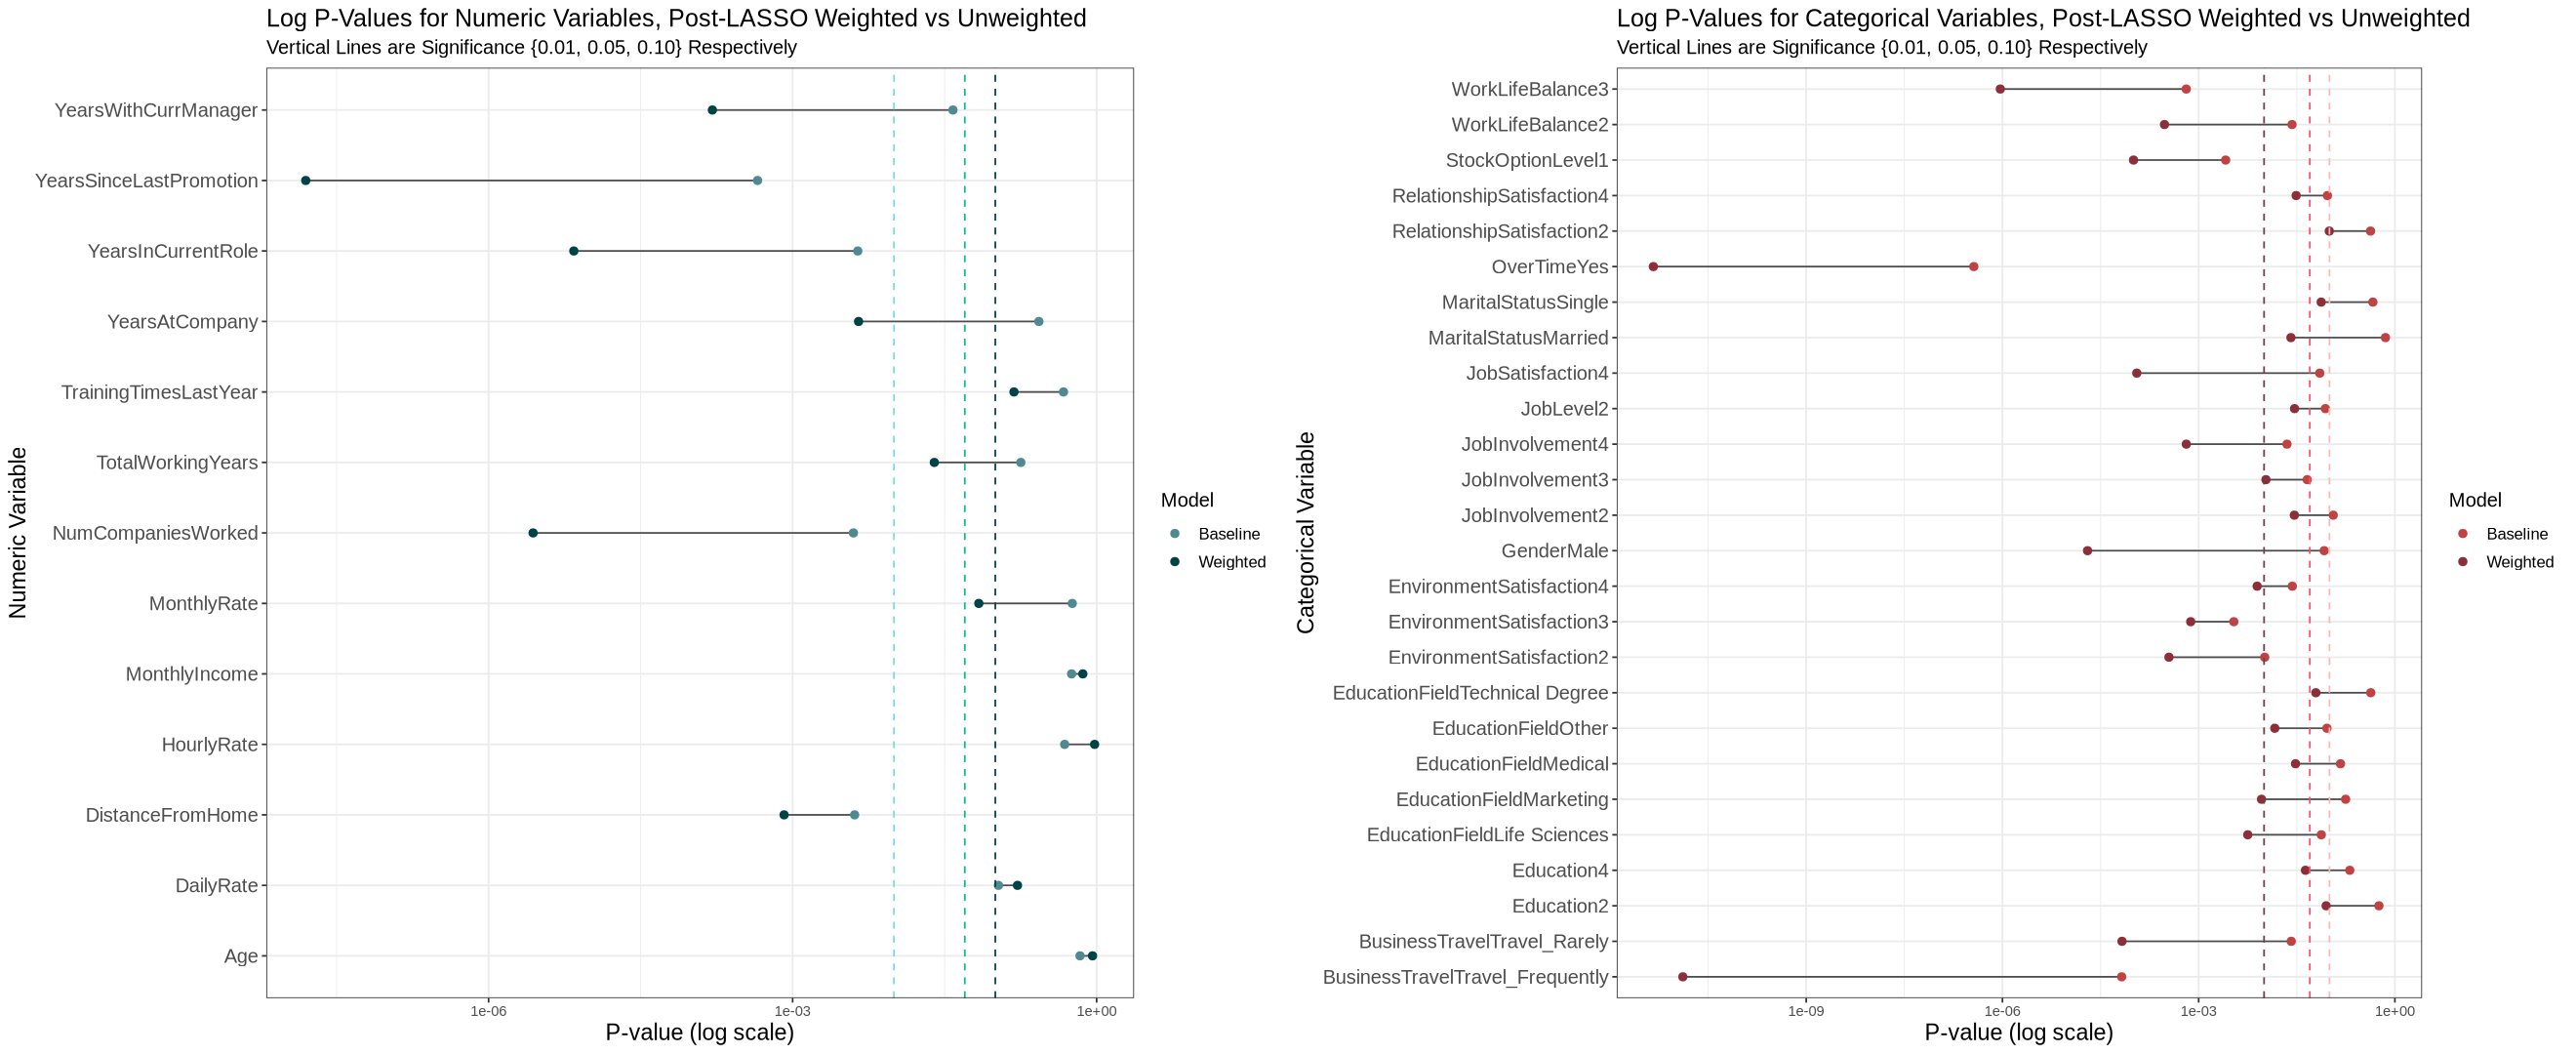

In [18]:
# Main developer: Caden
# ------------------- #
# -- Category Coef -- #
# ------------------- #
# for the second plot, we do the p-values of categorical columns
plotDF_C <- plotDF[!plotDF$variable %in% numeric_cols, ]
# however there are many more than numeric
# so we select only those with at least one significant at 0.10
plotDF_C <- plotDF_C[plotDF_C$Weighted < 0.10 | plotDF_C$Baseline < 0.10, ]
# we pivot the data to prepare it for plotting
plotDF_longC <- plotDF_C %>%
  pivot_longer(cols = c(Weighted, Baseline), 
               names_to = "Model", 
               values_to = "pval")

# create the plot of numeric coefficient p-values
pC <- ggplot(plotDF_longC, aes(x = pval, y = variable, color = Model)) +
  # add the line first so that its not on top of the points
  geom_line(aes(group = variable),
            color = "grey30",
            linewidth = 0.5) +
  # add points for p-values
  geom_point(size = 2) +
  # convert to log-scale for readability
  scale_x_log10() +
  labs(x = "P-value (log scale)", y = "Categorical Variable", color = "Model") +
  scale_color_manual(values = c(
    "Weighted" = "#8c2f39",
    "Baseline" = "#bf4342"
  )) +
  geom_vline(xintercept = 0.01,
             linetype = "dashed",
             color = "#723d46") +
  geom_vline(xintercept = 0.05,
             linetype = "dashed",
             color = "#ff4d6d") +
  geom_vline(xintercept = 0.10,
             linetype = "dashed",
             color = "#fcb9b2") +
  labs(title = "Log P-Values for Categorical Variables, Post-LASSO Weighted vs Unweighted", 
       subtitle = "Vertical Lines are Significance {0.01, 0.05, 0.10} Respectively") +
  theme_bw() +
  theme(
    axis.text.y = element_text(size = 12),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    plot.title = element_text(size = 15),
    plot.subtitle = element_text(size = 12),
    legend.text = element_text(size = 10),
    legend.title = element_text(size = 12)
  ) 
grid.arrange(pN, pC, ncol = 2)

**Interpretation of Figure 2 (outline)**
  - Both models selected basically the same variables. The weighted model selected Age when the unweighted did not; however, the coefficient for age was not statistically significant
  - Under the $F_{\beta}$ model, the log $p$-values tend to decrease, indicating a general increase in significance for the selected variables when attrition=yes is prioritized.
  - The magnitude of the change in $p$-values is indicated by the horizontal lines.
  - A few variables of note were not significant in the unweighted model, and became statistically significant in the weighted model. These include...
    - **Most interesting**: Crossing two or more vertical lines.
    - *These are some examples*: pick any that are worth talking about. Look for horizontal lines crossing two or more vertical lines.
    - `YearsAtCompany`: Not significant at any testing level (i.e. $p > 0.10$) in the unweighted model. Significant at $\alpha = 0.01$ (i.e. $p < 0.01$ for the weighted model.)
    - `TotalWorkingYears`: Not significant at $\alpha = 0.10$ in the unweighted model. Significant at $\alpha = 0.05$ (i.e. $p < 0.05$ for the weighted model.)
    - `GenderMale`: Not significant at $\alpha = 0.05$ (i.e. $p > 0.05$)  in the unweighted model. Significant at $\alpha = 0.05$ (i.e. $p < 0.05$ for the weighted model.)
    - `MaritalStatusMarried`: Not significant any testing level (i.e. $p > 0.10$) in the unweighted model. Significant at $\alpha = 0.01$ (i.e. $p < 0.01$ for the weighted model.)
    - `EducationField` (many different factor levels): Most were insignificant at $\alpha = 0.05$ in the unweighted model and significant at $\alpha = 0.05$ or even $\alpha = 0.01$ in the weighted model.

General comments: Those variables that were significant in the unweighted model generally remained significant (with $p$ decreasing) in the weighted model.
The variables selected all seem to have an impact on attrition=1. **Those that shifted the most likely have an even larger impact on attrition=1**. Discuss these in context?

## Discussion of Findings:

These key findings would be essential for the HR department to gain a deeper understanding of employee retention and identify areas that need improvement to enhance retention efforts. Additionally, the HR department could use this model to predict the likelihood of an employee leaving (attrition) based on their current characteristics. It could also be applied to evaluate the professional career history of future candidates prior to hiring, helping to identify any potential traits that could signal a higher risk of attrition

Categorical Variables to Highlight: 
`MaritalStatusMarried`, `JobSatisfaction4` , `GenderMale`, `EducationFieldMedical`, `EducationFieldMarketing`, `EducationFieldLifeSciences` , `Education4`

Numerical Variables to Highlight: 
`YearsWithCurrManager`, `YearsAtCompnay`,`TotalWorkingYears`

#### Future for HR Department:
Based on the findings, for the company's current employees, the HR Department can look into ways to improve `JobSatisfaction` such as through valued compenstation and benefits, through a transparent and productive culture, recognizing its employees, ample training and career development opportunites, essentially improving on ways to boost employee moral (DeLeon, 2022).

For incoming candidates, the HR department can look into their categorical variables such as their level and type of education, marital status and gender before hiring an employee. This however, raises an ethical concern with gender biases towards hiring more men than women, as well as discriminatory biases when looking into an employees maritial status. 

### Shortcomings of Research:

#### References

David, E. J., Schroeder, T. M., & Fernandez, J. (2019). Internalized racism: A systematic review of the psychological literature on racism’s most insidious consequence. Journal of Social Issues, 75(4), 1057–1086. https://doi.org/10.1111/josi.12350 

DeLeon, H. (2022, October 18). How to increase employee job satisfaction. Career Charge | USF CTPE Blog. https://corporatetraining.usf.edu/blog/how-to-increase-employee-job-satisfaction 

Friedman, J., Hastie, T., & Tibshirani, R. (2010). Regularization paths for generalized linear models via coordinate descent. Journal of Statistical Software, 33(1), 1–22. https://doi.org/10.18637/jss.v033.i01 

Frye, A., Boomhower, C., Smith, M., Vitovsky, L., & Fabricant, S. (2018). Employee Attrition: What Makes an Employee Quit? SMU Data Science Review, 1(1). https://scholar.smu.edu/datasciencereview/vol1/iss1/9/

Gayatri, Negi. (2013, July). EMPLOYEE ATTRITION: INEVITABLE YET MANAGEABLE. Academia.edu. https://www.academia.edu/21443767/EMPLOYEE_ATTRITION_INEVITABLE_YET_MANAGEABLE

Taha, A. A., & Hanbury, A. (2015). Metrics for evaluating 3D medical image segmentation: Analysis, selection, and tool. BMC Medical Imaging, 15(29), 1–28. https://doi.org/10.1186/s12880-015-0068-x 

Van Rijsbergen, C. J. (1979). Information Retrieval (Butterworth-Heinemann, Ed.; 2nd ed.) https://www.dcs.gla.ac.uk/Keith/Preface.html . 

Zou, Hui, and Trevor Hastie. 2005. Regularization and Variable Selection via the Elastic Net. Journal of the Royal Statistical Society: Series B (Statistical Methodology) 67 (2): 301–20. https://doi.org/10.1111/j.1467-9868.2005.00503.x.